# Setup 

In [59]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D, Input, Dropout, GlobalAveragePooling2D,concatenate
from PIL import Image
import numpy as np
import PIL.ImageOps 
import csv
import zipfile
import os
import cv2
from natsort import natsorted
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.utils.vis_utils import plot_model

In [2]:
!pip install split-folders --quiet

Mount to Google Drive folder. Make sure the folder `malaria_project` is inside `MyDrive`. If it is in `shared with me` right click and make a shortcut to `MyDrive`. 

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Variables:

In [133]:
BATCH_SIZE=32
EPOCHS = 5

### Setting up the satellite data
First we split the satellite images into `test`,`train`, and `validation` folders

# TODO: Change it such that the entire satellite folder is within malaria_project

In [5]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/x_data/x2", output="output",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False) # (train:validation:test)


Copying files: 5133 files [03:10, 26.97 files/s] 


As we are going to use `DataFrames` to our `ImageDataGenerators` we need to create them such that the entire filename is the `x_col` entry, and we can access the label. It is required that the name of the entry in `x_col` has the exact same name as the satellite image in order to match them.

In [6]:
'''
This function is responsible for creating the dataframe containing the labels and image data
'''
def createDataFrame(label_dir, data_dir, ending=True):
  #Retrieve the filenames and ids.
  filenames = []
  ids = []
  for file in os.listdir(data_dir):
    if file == ".DS_Store":
      continue
    filenames.append(file)
    if ending:
      ids.append(file.split("_")[0])
    else:
      ids.append(file.split(".")[0])
  #Create empty DataFrame
  df = pd.DataFrame()
  #Append the data
  df['filename'] = filenames
  df['id'] = ids

  #Append the labels
  start_list = []
  with open(label_dir) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for i,line in enumerate(csv_reader):
      #print(line[0])
      id = line[0]
      pr = line[4]
      for img in filenames:
        if ending:
          img_id = img.split('_')[0]
        else:
          img_id = img.split(".")[0]
          
        if img_id == id:
          index = np.where(df["filename"] == img)
          start_list.append(float(pr))
    df['label'] = start_list
  return df.sort_values(by='id')

Creating the `DataFrames`

In [11]:
train_data_dir = 'output/train/satellite_data_v2'
test_data_dir = 'output/test/satellite_data_v2'
val_data_dir = 'output/val/satellite_data_v2'
label_dir = '/content/drive/MyDrive/malaria_project/long_lat_year_with_confidential_from2010to18_size10orGreater.csv'
train_df = createDataFrame(label_dir=label_dir, data_dir=train_data_dir)
test_df = createDataFrame(label_dir=label_dir, data_dir=test_data_dir)
val_df = createDataFrame(label_dir=label_dir, data_dir=val_data_dir)

### Setting up the landcover data

In [12]:
'''Finding the names of the files that needs to be copied'''
x_names = []
for file_name in os.listdir("/content/drive/MyDrive/x_data/x2/satellite_data_v2"):
  x_names.append(file_name.split("_")[0])

In [13]:
'''Loops through the images and copies the corresponding land cover'''
import os
import shutil

source_folder = r"/content/drive/MyDrive/malaria_project/landcover_with_confi_2010_2018_size10andGreater"
if not os.path.exists('landcover_full'):
   os.makedirs('landcover_full')
destination_folder = r"landcover_full"

for file_name in os.listdir(source_folder):
  for x_name in x_names:
    if file_name.split(".")[0] == x_name:
      source = source_folder + "/"+ file_name
      destination = destination_folder + "/" + file_name
      shutil.copy(source, destination)

# TODO: Fix such that the landcover images has the correct size

In [14]:
#crop the landcovers
for i,image in enumerate(os.listdir("landcover_full")):
    if image == ".DS_Store" or image ==".ipynb_checkpoints":
        continue
    img = Image.open("landcover_full/"+image)
    if img.size != (8, 8):
      img = img.resize((8,8))
      img.save('landcover_full/'+image, 'TIFF')


As we have the images locally we can split it into folders. First we create all the directories and then we copy the images into the correct ones, according to the satellite data. 

In [175]:
#create the directories
if not os.path.exists('output_landcover/train/landcover'):
  os.makedirs('output_landcover/train/landcover')
if not os.path.exists('output_landcover/test/landcover'):
  os.makedirs('output_landcover/test/landcover')
if not os.path.exists('output_landcover/val/landcover'):
  os.makedirs('output_landcover/val/landcover')

In [16]:
'''Copies the files from the landcover directory to the correct splitted folders'''
def copyfiles(dir, src_dir, dest_dir):
  for file_name in os.listdir(dir):
    file_name_no_coords = file_name.split("_")[0]
    source = src_dir + file_name_no_coords + ".tiff"
    destination = dest_dir + file_name_no_coords + ".tiff"
    shutil.copy(source, destination)
  
copyfiles(dir="output/test/satellite_data_v2", src_dir="landcover_full/", dest_dir="output_landcover/test/landcover/")
copyfiles(dir="output/train/satellite_data_v2", src_dir="landcover_full/", dest_dir="output_landcover/train/landcover/")
copyfiles(dir="output/val/satellite_data_v2", src_dir="landcover_full/", dest_dir="output_landcover/val/landcover/")

Lastly we can create the `DataFrames`

In [17]:
train_data_dir_landcover = 'output_landcover/train/landcover'
test_data_dir_landcover = 'output_landcover/test/landcover'
val_data_dir_landcover = 'output_landcover/val/landcover'
label_dir_landcover = '/content/drive/MyDrive/malaria_project/long_lat_year_with_confidential_from2010to18_size10orGreater.csv'
train_landcover_df = createDataFrame(label_dir=label_dir_landcover, data_dir=train_data_dir_landcover, ending=False)
test_landcover_df = createDataFrame(label_dir=label_dir_landcover, data_dir=test_data_dir_landcover, ending=False)
val_landcover_df = createDataFrame(label_dir=label_dir_landcover, data_dir=val_data_dir_landcover, ending=False)

### Setting up the precipitation data

In [179]:
precipitation_dir = '/content/drive/MyDrive/malaria_project/precipitation_cropped_snips_with_confi_2010_2018_size10andGreater'

In [180]:
def create_precipitation_dataframe(data_dir):
  filenames = []
  ids = []
  for file in os.listdir(data_dir):
      if file == ".DS_Store":
        continue
      ids.append(file.split('.')[0])
      filenames.append(file)
  df = pd.DataFrame()
  df['filename'] = filenames
  df['id'] = ids
  return df.sort_values(by='id')

In [181]:
df = create_precipitation_dataframe(data_dir=precipitation_dir)

In [182]:
train_precipitation_df  = df[df['id'].isin(train_df['id'])]
val_precipitation_df    = df[df['id'].isin(val_df['id'])]
test_precipitation_df   = df[df['id'].isin(test_df['id'])]

In [216]:
train_data_dir_pre = 'output_precipitation/train/precipitation'
test_data_dir_pre  = 'output_precipitation/test/precipitation'
val_data_dir_pre   = 'output_precipitation/val/precipitation'

In [209]:
if os.path.exists('output_precipitation'):
  shutil.rmtree('output_precipitation')
#create directories
if not os.path.exists(train_data_dir_pre):
  os.makedirs(train_data_dir_pre)
if not os.path.exists(val_data_dir_pre):
  os.makedirs(val_data_dir_pre)
if not os.path.exists(test_data_dir_pre):
  os.makedirs(test_data_dir_pre)

In [210]:
#download the data
print("train")
for file_name in train_precipitation_df['filename']:
  print('\r', file_name, end='')
  source = precipitation_dir + "/" + file_name
  destination = "output_precipitation/train/precipitation/" + file_name
  shutil.copy(source, destination)
print("val")
for file_name in val_precipitation_df['filename']:
  print('\r', file_name, end='')
  source = precipitation_dir + "/" + file_name
  destination = "output_precipitation/val/precipitation/" + file_name
  shutil.copy(source, destination)
print("test")
for file_name in test_precipitation_df['filename']:
  print('\r', file_name, end='')
  source = precipitation_dir + "/" + file_name
  destination = "output_precipitation/test/precipitation/" + file_name
  shutil.copy(source, destination)

train
 999.tiffval
 998.tifftest
 963.tiff

In [215]:
print(len(os.listdir('output_precipitation/train/precipitation')))
print(len(os.listdir('output_precipitation/val/precipitation')))
print(len(os.listdir('output_precipitation/test/precipitation')))

3593
1026
514


## Constructing the `ImageDataGenerators`

In [100]:
'''
This function construct the generators.
'''
def construct_generators(train_df, train_dir, val_df, val_dir, test_df, test_dir, target_size, augmentations=dict(), x_col="filename", y_col="label"):
  params = dict(x_col=x_col,
                y_col=y_col, 
                has_ext=True,
                shuffle=True,
                batch_size=BATCH_SIZE, 
                class_mode="other", 
                target_size=target_size)

  train_generator = ImageDataGenerator(**augmentations)
  val_generator   = ImageDataGenerator(**augmentations)
  test_generator  = ImageDataGenerator(**augmentations)

  train_gen = train_generator.flow_from_dataframe(dataframe=train_df,directory=train_dir,**params)
  val_gen   = val_generator.flow_from_dataframe(dataframe=val_df,directory=val_dir,**params)
  test_gen  = test_generator.flow_from_dataframe(dataframe=test_df,directory=test_dir,**params)

  return train_gen, val_gen, test_gen

In [245]:
traingen_sat, valgen_sat, testgen_sat = construct_generators(train_df,
                                                            train_data_dir,
                                                            val_df,
                                                            val_data_dir,
                                                            test_df,
                                                            test_data_dir, 
                                                            (1024,1024))
traingen_lc, valgen_lc, testgen_lc = construct_generators(train_landcover_df,
                                                            train_data_dir_landcover,
                                                            val_landcover_df,
                                                            val_data_dir_landcover,
                                                            test_landcover_df,
                                                            test_data_dir_landcover, 
                                                            (8,8))
traingen_pre, valgen_pre, testgen_pre = construct_generators(train_precipitation_df, 
                                                            train_data_dir_pre,
                                                            val_precipitation_df,
                                                            val_data_dir_pre,
                                                            test_precipitation_df,
                                                            test_data_dir_pre,
                                                            (1,1),
                                                            x_col="filename",
                                                            y_col="id"
                                                            )

Found 3593 validated image filenames.
Found 1026 validated image filenames.
Found 514 validated image filenames.
Found 3593 validated image filenames.
Found 1026 validated image filenames.
Found 514 validated image filenames.
Found 3593 validated image filenames.
Found 1026 validated image filenames.
Found 514 validated image filenames.


In [246]:
class JoinedGen(tensorflow.keras.utils.Sequence):
    '''
    This clas is reponsible for manipulating the outputs of the generators 
    to have the correct form which our model can take as input. It takes two 
    ImageDataGenerator instances as input.

    Args: 
        input_sat: An ImageDataGenerator instance for satelitte data
        input_lc:  An ImageDataGenerator instance for landcover data
        input_pre: An ImageDataGenerator instance for precipitation data 
    '''
    def __init__(self, input_sat, input_lc, input_pre):
        self.gen_sat = input_sat
        self.gen_lc  = input_lc
        self.gen_pre = input_pre

        assert len(input_sat) == len(input_lc) == len(input_pre)

    def __len__(self):
        return len(self.gen_sat)

    def __getitem__(self, i):
        x1,y1 = self.gen_sat[i]
        x2,_ = self.gen_lc[i]
        x3,_ = self.gen_pre[i]

        return [x1,x2,x3],y1 #as the labels are always the same, we can simply output the first.

    def on_epoch_end(self):
        self.gen_sat.on_epoch_end()
        self.gen_lc.on_epoch_end()
        self.gen_pre.on_epoch_end()
        #shuffling
        self.gen_sat.index_array = self.gen_sat.index_array 
        self.gen_lc.index_array = self.gen_sat.index_array 
        self.gen_pre.index_array = self.gen_sat.index_array

## Constructing the model

In [248]:
'''Toy model'''
sat_input = keras.Input(shape=(1024,1024,3))
lc_input = keras.Input(shape=(8,8,3))
precipitation_input = keras.Input(shape=(1,1,3))

x = MaxPooling2D((128,128))(sat_input)
x = concatenate([x,lc_input])
x = MaxPooling2D((8,8))(x)
x = concatenate([x,precipitation_input])
x = Flatten()(x)
x = Dense(1, activation="linear")(x)
new_simple_model = Model(inputs=[sat_input, lc_input, precipitation_input], outputs=x) 
new_simple_model.compile(optimizer='adam', loss='mse')
summary = new_simple_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 8, 8, 3)     0           ['input_42[0][0]']               
 )                                                                                                
                                                                                                  
 input_43 (InputLayer)          [(None, 8, 8, 3)]    0           []                               
                                                                                           

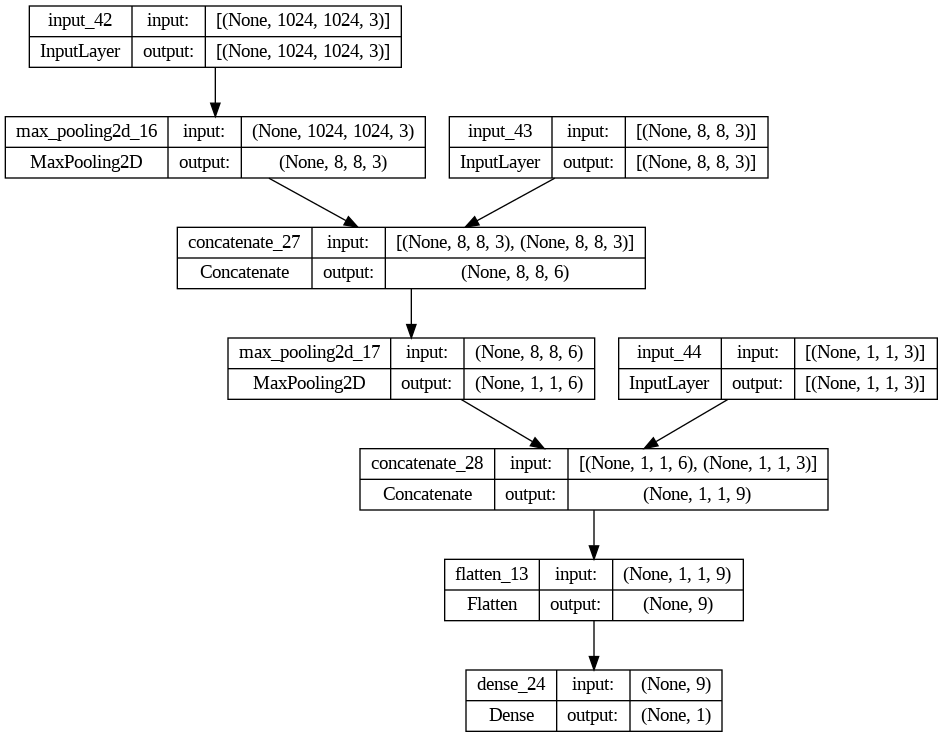

In [249]:
plot_model(new_simple_model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [250]:
my_gen = JoinedGen(traingen_sat, traingen_lc, traingen_pre)
vgg_history = new_simple_model.fit(my_gen,
                            batch_size=BATCH_SIZE,
                            epochs=1,#EPOCHS,
                            steps_per_epoch=traingen_sat.samples//BATCH_SIZE,
                            #validation_data=val_generator,
                            #,
                            #validation_steps=n_val_steps,
                            #callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

112/112 [==============================] - 196s 2s/step - loss: 9580.7373
